In [ ]:
# First, try reinstalling
# !pip uninstall normalizer -y
!pip install normalizer

# Or try a different version
# !pip install normalizer

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install --upgrade transformers
!pip install torch transformers datasets pandas scikit-learn

Using: cuda
Data: (6000, 4), Labels: {1: 3000, 0: 3000}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Training XLM-R...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.581100,0.592788,0.701667,0.701600,0.701848,0.701667


Free disk space: 0.00 GB
Free disk space: 0.00 GB
Training complete!



Results: Acc=0.718, F1=0.718, AUC=0.772
Evaluation failed: [Errno 28] No space left on device
Model save failed: No space left on device (os error 28)
'আমি তোমাকে ভালোবাসি।' -> Non-Hate (0.816)
'You are terrible!' -> Non-Hate (0.658)
'Je te déteste!' -> Non-Hate (0.807)
'Ich liebe dich' -> Non-Hate (0.700)

🎉 Done! Use predict('text') for multilingual inference


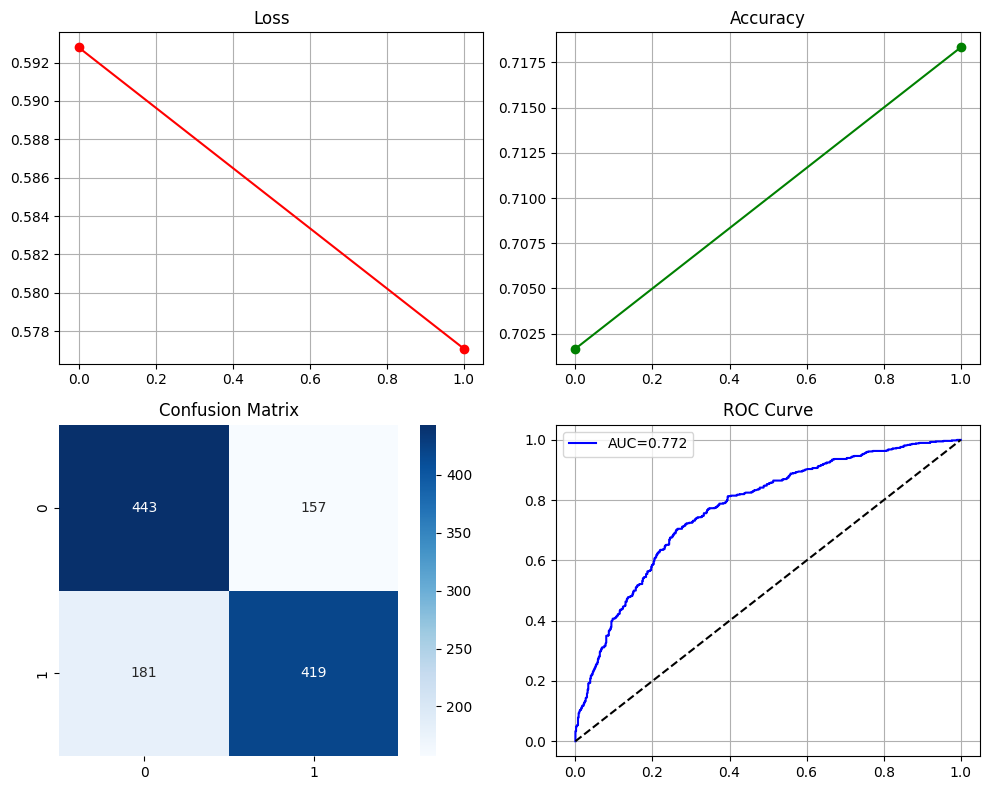

In [17]:
# XLM-R Hate Speech Detection - Ultra Compact (FIXED)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')
import gc
import os

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Text normalizer (simple for XLM-R)
def normalize_text(text):
    return str(text).strip().replace('\n', ' ').replace('\r', ' ')

# Process data
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(normalize_text)
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})
print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2).to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Enhanced Trainer with memory management
class QuickTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): 
            self.history[k].append(v)
    
    def _save_checkpoint(self, model, trial):
        # Clean up before saving
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # Check disk space before saving
        output_dir = self.args.output_dir
        if os.path.exists(output_dir):
            statvfs = os.statvfs(output_dir)
            free_space_gb = (statvfs.f_frsize * statvfs.f_bavail) / (1024**3)
            print(f"Free disk space: {free_space_gb:.2f} GB")
            
            if free_space_gb < 2:  # Less than 2GB free
                print("Warning: Low disk space! Skipping checkpoint save.")
                return
        
        try:
            super()._save_checkpoint(model, trial)
        except Exception as e:
            print(f"Checkpoint save failed: {e}")
            # Continue training without saving
            pass

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Create output directory with better path
output_dir = './xlmr_results'
os.makedirs(output_dir, exist_ok=True)

# Train - FIXED Configuration
trainer = QuickTrainer(
    model=model,
    args=TrainingArguments(
        output_dir=output_dir,
        eval_strategy="steps", 
        save_strategy="steps",
        learning_rate=1e-5, 
        per_device_train_batch_size=16, 
        per_device_eval_batch_size=32,
        num_train_epochs=4, 
        weight_decay=0.1, 
        logging_steps=50, 
        report_to="none",
        load_best_model_at_end=True, 
        metric_for_best_model="eval_f1", 
        greater_is_better=True,
        fp16=torch.cuda.is_available(), 
        dataloader_num_workers=0, 
        warmup_steps=300,
        # FIXED: Less frequent saves and limited checkpoints
        eval_steps=500,  # Increased from 200
        save_steps=500,  # Increased from 200
        save_total_limit=2,  # Only keep 2 checkpoints
        gradient_accumulation_steps=2, 
        max_grad_norm=1.0,
        # Additional memory optimizations
        remove_unused_columns=True,
        prediction_loss_only=False,
        save_safetensors=True,  # More efficient saving format
    ),
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset, 
    compute_metrics=compute_metrics,
)

print("Training XLM-R...")
try:
    trainer.train()
    print("Training complete!")
except Exception as e:
    print(f"Training failed: {e}")
    # Try to save what we have
    try:
        model.save_pretrained('./xlmr_model_partial')
        tokenizer.save_pretrained('./xlmr_model_partial')
        print("Partial model saved!")
    except:
        print("Could not save partial model")

# Clean up before evaluation
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Evaluate
try:
    preds = trainer.predict(eval_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = preds.label_ids
    y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

    results = trainer.evaluate()
    auc = roc_auc_score(y_true, y_prob)
    print(f"\nResults: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

    # Plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    if 'eval_loss' in trainer.history:
        axes[0,0].plot(trainer.history['eval_loss'], 'r-o'); axes[0,0].set_title('Loss'); axes[0,0].grid()
    if 'eval_accuracy' in trainer.history:
        axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o'); axes[0,1].set_title('Accuracy'); axes[0,1].grid()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues'); axes[1,0].set_title('Confusion Matrix')
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1,1].plot(fpr, tpr, 'b-', label=f'AUC={auc:.3f}')
    axes[1,1].plot([0,1], [0,1], 'k--'); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
    plt.tight_layout(); plt.savefig('xlmr_results.png', dpi=300, bbox_inches='tight'); plt.show()

except Exception as e:
    print(f"Evaluation failed: {e}")

# Save final model
try:
    model.save_pretrained('./xlmr_model')
    tokenizer.save_pretrained('./xlmr_model')
    print("XLM-R model saved!")
except Exception as e:
    print(f"Model save failed: {e}")

# Hugging Face deploy
def deploy_to_hf(username, model_name="xlmr-hate-speech"):
    try:
        from huggingface_hub import login, HfApi
        login()  # Enter your HF token
        repo_id = f"{username}/{model_name}"
        model.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"✅ Model deployed: https://huggingface.co/{repo_id}")
        return repo_id
    except Exception as e:
        print(f"❌ Deploy failed: {e}")
        return None

# Uncomment to deploy: deploy_to_hf("your_username")

def predict(text):
    inputs = tokenizer(normalize_text(text), return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    pred = torch.argmax(probs).item()
    return {'text': text, 'prediction': 'Hate' if pred == 1 else 'Non-Hate', 'confidence': probs.max().item()}

# Test multilingual
for text in ["আমি তোমাকে ভালোবাসি।", "You are terrible!", "Je te déteste!", "Ich liebe dich"]:
    try:
        result = predict(text)
        print(f"'{text}' -> {result['prediction']} ({result['confidence']:.3f})")
    except Exception as e:
        print(f"Prediction failed for '{text}': {e}")

print("\n🎉 Done! Use predict('text') for multilingual inference")

# Quick inference function

In [ ]:
def predict(text):
    inputs = tokenizer(normalize_text(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    pred = torch.argmax(probs).item()
    
    return {
        'text': text,
        'prediction': 'Hate' if pred == 1 else 'Non-Hate',
        'confidence': probs.max().item(),
        'hate_prob': probs[1].item()
    }

# Test
name_input = input("Enter text: ")
result = predict(name_input)
print(f"\n'{result['text']}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")